<a href="https://colab.research.google.com/github/devt2326/clipboardhealth/blob/main/cbh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: display settings for cleaner visuals
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [ ]:
# Load data
df = pd.read_csv('shifts_offer.csv')

# Preview
df.head(5)


,SHIFT_ID,WORKER_ID,WORKPLACE_ID,SHIFT_START_AT,SHIFT_CREATED_AT,OFFER_VIEWED_AT,DURATION,SLOT,CLAIMED_AT,DELETED_AT,IS_VERIFIED,CANCELED_AT,IS_NCNS,PAY_RATE,CHARGE_RATE
0,6757580b1e2d97752fd69167,65b01f2e46c0645699081cbe,5e7e45243bfbb200165914ae,2024-12-09 23:00:00,2024-12-09 20:50:19,2024-12-09 21:18:42,8,pm,NaN,NaN,False,NaN,False,21.29,29
1,675d37d8a1ca6192a74d23f4,65298a18cc967a5cebbd40b6,5e1ce78827ff480016e9133e,2024-12-14 22:30:00,2024-12-14 7:46:32,2024-12-14 13:19:30,9,pm,NaN,2024-12-14 19:23:43,False,NaN,False,23.23,30
2,67550bddd79613f860549322,6696d1c1d0200bf317ee5d3c,626b0b89596c0601c2c39642,2024-12-08 15:00:00,2024-12-08 3:00:46,2024-12-08 4:04:14,6,am,NaN,NaN,False,NaN,False,21.97,30
3,66f5d05de01fd3697b18c206,66b285d5d0200bf317738e59,5cb9f07135163900163f532c,2024-09-27 14:00:00,2024-09-26 21:21:34,2024-09-27 4:19:45,8,am,NaN,NaN,False,NaN,False,19.05,28
4,66ee3848e62bb5f43e3baee5,620c6429e2ceb601ad203920,611af67795f4c501662edb31,2024-10-08 21:30:00,2024-09-21 3:06:48,2024-10-06 0:46:37,8,pm,NaN,NaN,False,NaN,False,22.13,24


In [ ]:
# Convert to datetime
datetime_cols = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'CANCELED_AT', 'DELETED_AT']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# View nulls
df.isnull().sum()


,0
SHIFT_ID,0
WORKER_ID,0
WORKPLACE_ID,0
SHIFT_START_AT,0
SHIFT_CREATED_AT,0
OFFER_VIEWED_AT,0
DURATION,0
SLOT,0
CLAIMED_AT,253276
DELETED_AT,210696


In [ ]:
# ➕ Add boolean flags
df['claimed'] = df['CLAIMED_AT'].notnull()
df['canceled'] = df['CANCELED_AT'].notnull()
df['deleted'] = df['DELETED_AT'].notnull()
df['verified'] = df['IS_VERIFIED'] == True
df['no_show'] = df['IS_NCNS'] == True

# 💰 Revenue for verified shifts only
df['revenue'] = (df['CHARGE_RATE'] - df['PAY_RATE']) * df['DURATION']
df['revenue'] = df['revenue'].where(df['verified'], 0)

# ✅ Identify shifts that were claimed / verified at least once
claimed_shifts_df = df.groupby('SHIFT_ID')['claimed'].any().reset_index().rename(columns={'claimed': 'shift_claimed'})
verified_shifts_df = df.groupby('SHIFT_ID')['verified'].any().reset_index().rename(columns={'verified': 'shift_verified'})
deleted_shifts_df = df.groupby('SHIFT_ID')['deleted'].any().reset_index(name='shift_deleted')

# 🔁 Merge all shift-level flags
shift_status = claimed_shifts_df.merge(verified_shifts_df, on='SHIFT_ID') \
                                .merge(deleted_shifts_df, on='SHIFT_ID')

# 🔢 Aggregated counts
unique_shifts = shift_status['SHIFT_ID'].nunique()
claimed_shifts = shift_status['shift_claimed'].sum()
verified_shifts = shift_status['shift_verified'].sum()
deleted_shifts = shift_status['shift_deleted'].sum()
total_canceled = df['canceled'].sum()
total_deleted = df['deleted'].sum()
total_no_show = df['no_show'].sum()
total_revenue = df['revenue'].sum()

# 📊 Final metrics (updated)
updated_metrics = {
    "Unique Shifts": unique_shifts,
    "Unique Facilities": df['WORKPLACE_ID'].nunique(),
    "Unique Workers": df['WORKER_ID'].nunique(),
    "Total Revenue (Verified Shifts Only)": total_revenue,
    "Claim Rate (Shifts Claimed / Unique Shifts)": claimed_shifts / unique_shifts,
    "Cancel Rate (Canceled / Claimed Offers)": total_canceled / df['claimed'].sum(),
    "No-show Rate (No-show / Claimed Offers)": total_no_show / df['claimed'].sum(),
    "Deletion Rate (Shifts Deleted / Unique Shifts)": deleted_shifts / unique_shifts,
    "Conversion Rate (Verified Shifts / Unique Shifts)": verified_shifts / unique_shifts
}

# Format output: % for rates, 2 decimals for counts
formatted_metrics = []
for key, value in updated_metrics.items():
    if "Rate" in key:
        formatted_value = f"{value * 100:.2f}%"
    else:
        formatted_value = f"{value:,.2f}"
    formatted_metrics.append((key, formatted_value))

# Display as DataFrame
metrics_df = pd.DataFrame(formatted_metrics, columns=["Metric", "Value"])
display(metrics_df)

,Metric,Value
0,Unique Shifts,"19,900.00"
1,Unique Facilities,132.00
2,Unique Workers,"10,291.00"
3,Total Revenue (Verified Shifts Only),"612,578.02"
4,Claim Rate (Shifts Claimed / Unique Shifts),64.33%
5,Cancel Rate (Canceled / Claimed Offers),2.46%
6,No-show Rate (No-show / Claimed Offers),0.24%
7,Deletion Rate (Shifts Deleted / Unique Shifts),18.45%
8,Conversion Rate (Verified Shifts / Unique Shifts),63.02%


<ipython-input-5-8517cb5b83e7>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shift_rate_claim = shift_level.groupby('pay_rate_bin')['claimed'].mean().reset_index()


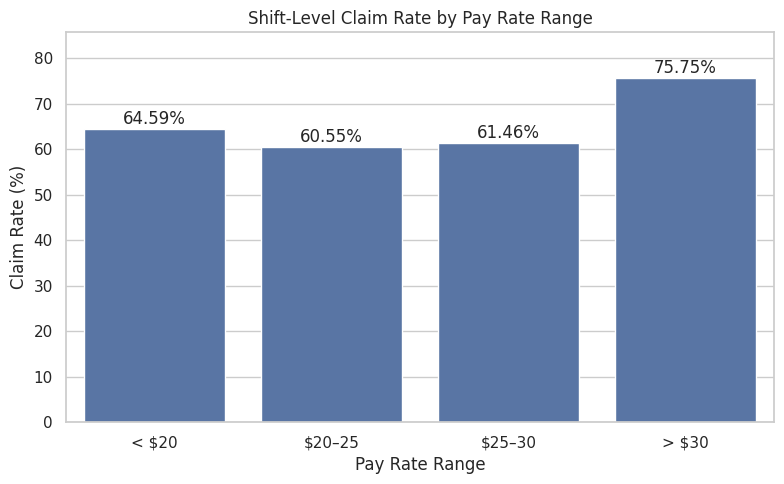

In [ ]:
# For each shift, get max pay_rate and whether it was claimed at least once
shift_level = df.groupby('SHIFT_ID').agg({
    'PAY_RATE': 'max',
    'claimed': 'any'
}).reset_index()

# Create pay rate bins
bins = [0, 20, 25, 30, 50]
labels = ['< $20', '$20–25', '$25–30', '> $30']
shift_level['pay_rate_bin'] = pd.cut(shift_level['PAY_RATE'], bins=bins, labels=labels)

# Now calculate shift-level claim rate by pay_rate_bin
shift_rate_claim = shift_level.groupby('pay_rate_bin')['claimed'].mean().reset_index()
shift_rate_claim['claimed_pct'] = shift_rate_claim['claimed'] * 100

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='pay_rate_bin', y='claimed_pct', data=shift_rate_claim)

for index, row in shift_rate_claim.iterrows():
    plt.text(index, row['claimed_pct'] + 1, f"{row['claimed_pct']:.2f}%", ha='center')

plt.title("Shift-Level Claim Rate by Pay Rate Range")
plt.ylabel("Claim Rate (%)")
plt.xlabel("Pay Rate Range")
plt.ylim(0, shift_rate_claim['claimed_pct'].max() + 10)
plt.tight_layout()
plt.show()


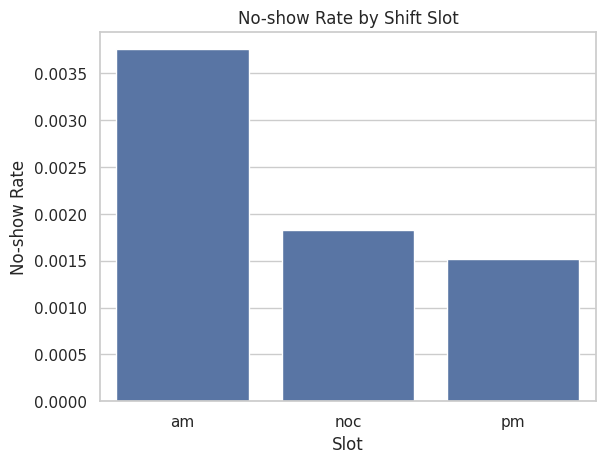

In [ ]:
df['no_show'] = df['IS_NCNS'].fillna(False)
slot_noshow = df[df['claimed']].groupby('SLOT')['no_show'].mean().reset_index()

sns.barplot(x='SLOT', y='no_show', data=slot_noshow)
plt.title("No-show Rate by Shift Slot")
plt.ylabel("No-show Rate")
plt.xlabel("Slot")
plt.show()


In [ ]:
# Step 1: Build shift-level view
shift_slot_claim = df.groupby('SHIFT_ID').agg({
    'SLOT': 'first',            # shift type: AM, PM, NOC
    'claimed': 'any',           # was the shift claimed at least once?
    'deleted': 'any'            # was the shift deleted?
}).reset_index()

# Step 2: Calculate claim & deletion counts by slot
slot_stats = shift_slot_claim.groupby('SLOT').agg(
    total_shifts=('SHIFT_ID', 'count'),
    claimed_shifts=('claimed', 'sum'),
    deleted_shifts=('deleted', 'sum')
).reset_index()

# Step 3: Calculate claim and deletion rates
slot_stats['claim_rate'] = (slot_stats['claimed_shifts'] / slot_stats['total_shifts']) * 100
slot_stats['deletion_rate'] = (slot_stats['deleted_shifts'] / slot_stats['total_shifts']) * 100

# Step 4: Sort and display
slot_stats = slot_stats.sort_values('claim_rate', ascending=False)
display(slot_stats)


,SLOT,total_shifts,claimed_shifts,deleted_shifts,claim_rate,deletion_rate
1,noc,4631,3209,761,69.293889,16.432736
2,pm,8218,5164,1726,62.837673,21.002677
0,am,7051,4429,1184,62.813785,16.791944


In [ ]:
# Revenue lost from no-shows
df['revenue_lost'] = np.where(df['IS_NCNS'], (df['CHARGE_RATE'] - df['PAY_RATE']) * df['DURATION'], 0)
print(f"Total estimated revenue lost due to no-shows: ${df['revenue_lost'].sum():,.2f}")



Total estimated revenue lost due to no-shows: $1,922.88


In [ ]:
# Merge claim and deletion flags
claim_delete_df = shift_status[['SHIFT_ID', 'shift_claimed', 'shift_deleted']]

# Crosstab analysis
claim_delete_ct = pd.crosstab(claim_delete_df['shift_claimed'], claim_delete_df['shift_deleted'], normalize='index') * 100
display(claim_delete_ct)


shift_deleted,False,True
shift_claimed,,
False,50.986193,49.013807
True,98.500234,1.499766


In [ ]:
# Get one row per shift with workplace and deleted flag
shift_level_df = df.groupby('SHIFT_ID').agg({
    'WORKPLACE_ID': 'first',
    'deleted': 'any'
}).reset_index()

# Deletion counts + rate per workplace
workplace_deletion = shift_level_df.groupby('WORKPLACE_ID').agg(
    total_shifts=('SHIFT_ID', 'count'),
    deleted_shifts=('deleted', 'sum')
).reset_index()

# Calculate percentage
workplace_deletion['deleted_pct'] = (workplace_deletion['deleted_shifts'] / workplace_deletion['total_shifts']) * 100

# Sort by number of deleted shifts
workplace_deletion_sorted = workplace_deletion.sort_values('deleted_pct', ascending=False)

# Display top 10 workplaces
display(workplace_deletion_sorted.head(10))


,WORKPLACE_ID,total_shifts,deleted_shifts,deleted_pct
31,5f4d42e3d621a000165c5cfd,36,35,97.222222
69,61b8fee2167e2201801e6b16,5,4,80.000000
42,5ff4f626909f7a00160d06fd,113,89,78.761062
46,602ed7d4c778ed00169bf292,11,7,63.636364
4,5c82b3dfa08cb800166dc04d,115,59,51.304348
98,638f685562e61b01b6719d8f,14,6,42.857143
120,6564d795a3497ddd40ab079f,48,20,41.666667
47,6081f3fc667fa6016195942c,90,36,40.000000
129,66b3ab3c0e400bcd45f4ae16,68,26,38.235294
5,5cb9f07135163900163f532c,311,115,36.977492


array([[<Axes: title={'center': 'shift_lifespan'}>]], dtype=object)

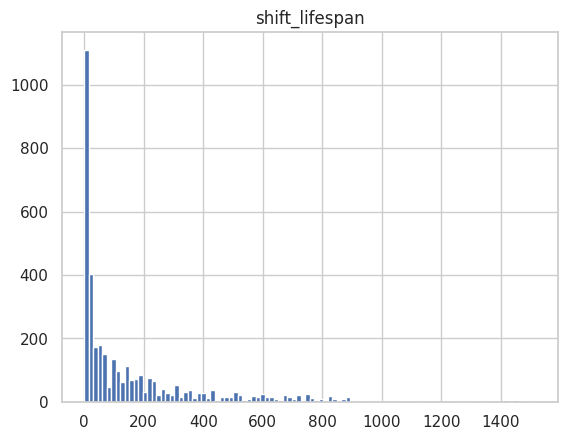

In [ ]:
# Get time from creation to deletion
df['shift_lifespan'] = (df['DELETED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600  # in hours

# Analyze only deleted shifts
deleted_shift_times = df[df['deleted']].groupby('SHIFT_ID')['shift_lifespan'].min().reset_index()
deleted_shift_times.hist(column='shift_lifespan', bins=100)


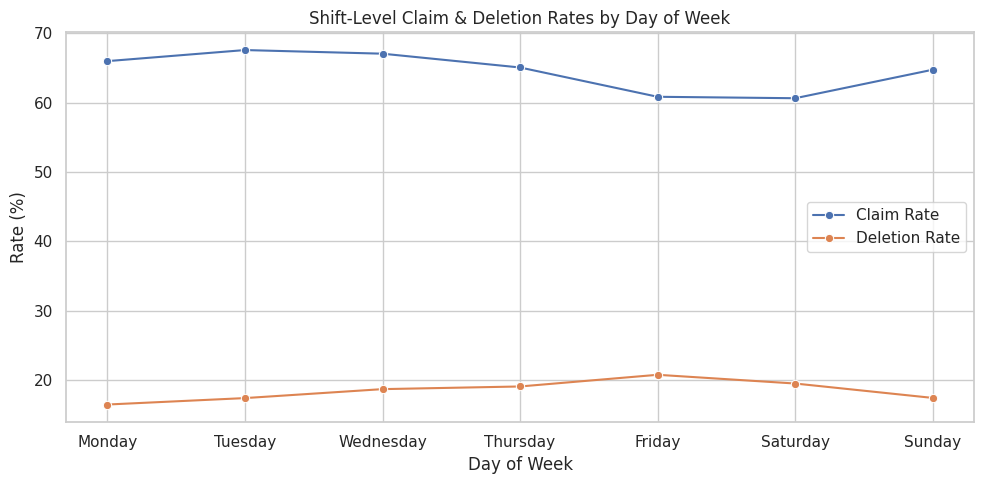

,shift_day,total_shifts,claim_rate,deletion_rate
1,Monday,2957,66.012851,16.469395
5,Tuesday,2368,67.609797,17.398649
6,Wednesday,2306,67.085863,18.690373
4,Thursday,2312,65.095156,19.074394
0,Friday,2765,60.867993,20.759494
2,Saturday,3513,60.660404,19.499004
3,Sunday,3679,64.773036,17.423213


In [ ]:
# Step 1: Build a shift-level DataFrame
shift_df = df.groupby('SHIFT_ID').agg({
    'SHIFT_START_AT': 'first',
    'claimed': 'any',
    'deleted': 'any'
}).reset_index()

# Step 2: Extract day of week
shift_df['shift_day'] = shift_df['SHIFT_START_AT'].dt.day_name()

# Step 3: Aggregate shift-level claim & deletion rates by day
day_stats = shift_df.groupby('shift_day').agg(
    total_shifts=('SHIFT_ID', 'count'),
    claim_rate=('claimed', 'mean'),
    deletion_rate=('deleted', 'mean')
).reset_index()

# Optional: reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats['shift_day'] = pd.Categorical(day_stats['shift_day'], categories=day_order, ordered=True)
day_stats = day_stats.sort_values('shift_day')

# Format as percentages
day_stats['claim_rate'] *= 100
day_stats['deletion_rate'] *= 100

import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='shift_day', y='claim_rate', data=day_stats, marker='o', label='Claim Rate')
sns.lineplot(x='shift_day', y='deletion_rate', data=day_stats, marker='o', label='Deletion Rate')

# Chart formatting
plt.title("Shift-Level Claim & Deletion Rates by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Rate (%)")
plt.xticks(rotation=0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

display(day_stats)


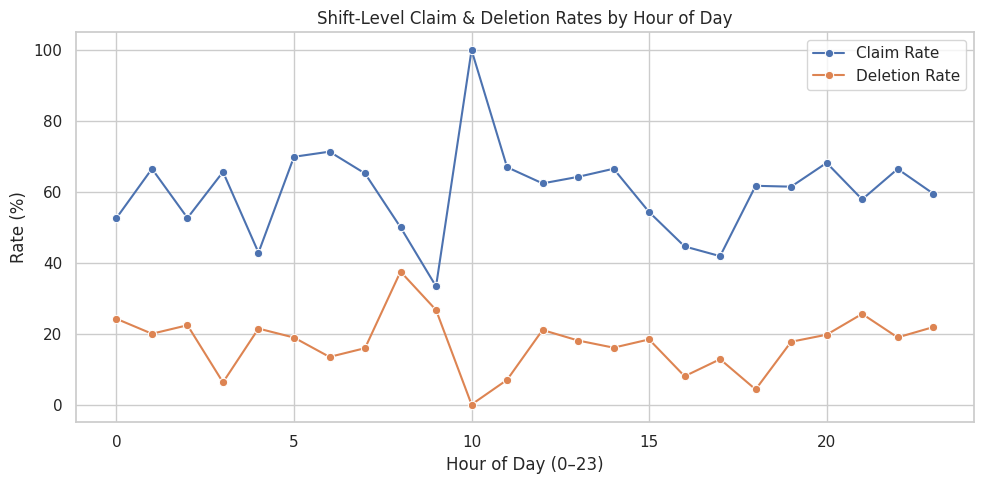

,shift_hour,total_shifts,claim_rate,deletion_rate
0,0,306,52.614379,24.183007
1,1,636,66.509434,19.968553
2,2,76,52.631579,22.368421
3,3,32,65.625000,6.250000
4,4,14,42.857143,21.428571
5,5,1355,69.889299,18.892989
6,6,2271,71.334214,13.430207
7,7,698,65.186246,15.902579
8,8,16,50.000000,37.500000
9,9,15,33.333333,26.666667


In [ ]:
# Step 1: Create shift-level DataFrame (if not already created)
shift_df = df.groupby('SHIFT_ID').agg({
    'SHIFT_START_AT': 'first',
    'claimed': 'any',
    'deleted': 'any'
}).reset_index()

# Step 2: Extract hour of shift start
shift_df['shift_hour'] = shift_df['SHIFT_START_AT'].dt.hour  # 0 to 23

# Step 3: Aggregate by hour
hour_stats = shift_df.groupby('shift_hour').agg(
    total_shifts=('SHIFT_ID', 'count'),
    claim_rate=('claimed', 'mean'),
    deletion_rate=('deleted', 'mean')
).reset_index()

# Convert to percentages
hour_stats['claim_rate'] *= 100
hour_stats['deletion_rate'] *= 100

# 📊 Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(x='shift_hour', y='claim_rate', data=hour_stats, marker='o', label='Claim Rate')
sns.lineplot(x='shift_hour', y='deletion_rate', data=hour_stats, marker='o', label='Deletion Rate')

plt.title("Shift-Level Claim & Deletion Rates by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: see table
display(hour_stats)


In [ ]:
# Calculate shift end datetime by adding duration (in hours) to start time
df['shift_end_at'] = df['SHIFT_START_AT'] + pd.to_timedelta(df['DURATION'], unit='h')

# Check date range of shift data
min_date = df['SHIFT_CREATED_AT'].min()
max_date = df['shift_end_at'].max()

print(f"Date Range of Data: {min_date.date()} to {max_date.date()}")
print(f"No. of days: {(max_date - min_date).days} days")


Date Range of Data: 2024-07-29 to 2025-01-21
No. of days: 175 days


In [ ]:
# Filter one row per shift and only include deleted shifts
deleted_shifts_df = df[df['deleted']].groupby('SHIFT_ID').agg({
    'DURATION': 'first',
    'CHARGE_RATE': 'first',
    'PAY_RATE': 'first'
}).reset_index()

# Calculate lost revenue
deleted_shifts_df['lost_revenue'] = (deleted_shifts_df['CHARGE_RATE'] - deleted_shifts_df['PAY_RATE']) * deleted_shifts_df['DURATION']

# Total lost revenue
total_lost_revenue = deleted_shifts_df['lost_revenue'].sum()

print(f"Estimated Lost Revenue (Deleted Shifts Only): ${total_lost_revenue:,.2f}")


Estimated Lost Revenue (Deleted Shifts Only): $231,278.17


In [ ]:
# Step 1: Count offers per shift
offers_per_shift = df.groupby('SHIFT_ID').agg(
    total_offers=('SHIFT_ID', 'count'),
    shift_claimed=('claimed', 'any')
).reset_index()

# Step 2: Average offers per claimed shift
avg_offers_per_claimed_shift = offers_per_shift[offers_per_shift['shift_claimed']]['total_offers'].mean()

print(f"📦 Average Offers per Claimed Shift (Overall): {avg_offers_per_claimed_shift:.2f}")


📦 Average Offers per Claimed Shift (Overall): 7.29


In [ ]:
# Filter only claimed offers
claimed_df = df[df['claimed']].copy()

# Calculate time between posting and claiming (in hours)
claimed_df['time_to_claim_hours'] = (claimed_df['CLAIMED_AT'] - claimed_df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600

# Take the minimum time_to_claim per shift (in case of multiple offers)
claim_time_per_shift = claimed_df.groupby('SHIFT_ID')['time_to_claim_hours'].min().reset_index()

# Average time to claim (in hours and days)
avg_hours = claim_time_per_shift['time_to_claim_hours'].mean()
avg_days = avg_hours / 24

print(f"⏳ Average Time to Claim a Shift: {avg_hours:.2f} hours ({avg_days:.2f} days)")


⏳ Average Time to Claim a Shift: 39.66 hours (1.65 days)


In [ ]:
# Filter only claimed offers
claimed_df = df[df['claimed']].copy()

# Calculate time between posting and claiming (in hours)
claimed_df['time_to_claim_hours'] = (claimed_df['SHIFT_START_AT'] - claimed_df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600

# Take the minimum time_to_claim per shift (in case of multiple offers)
claim_time_per_shift = claimed_df.groupby('SHIFT_ID')['time_to_claim_hours'].min().reset_index()

# Average time to claim (in hours and days)
avg_hours = claim_time_per_shift['time_to_claim_hours'].mean()
avg_days = avg_hours / 24

print(f"⏳ Average Time between shifts created and shift start: {avg_hours:.2f} hours ({avg_days:.2f} days)")


⏳ Average Time between shifts created and shift start: 158.39 hours (6.60 days)


In [ ]:
# Filter deleted shifts only
deleted_df = df[df['deleted']].copy()

# Calculate lead time in hours
deleted_df['lead_time_hours'] = (deleted_df['SHIFT_START_AT'] - deleted_df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600

# Summary statistics
avg_lead_hours = deleted_df['lead_time_hours'].mean()
avg_lead_days = avg_lead_hours / 24

print(f"🗓️ Average Lead Time for Deleted Shifts: {avg_lead_hours:.2f} hours ({avg_lead_days:.2f} days)")


🗓️ Average Lead Time for Deleted Shifts: 251.58 hours (10.48 days)


In [ ]:
# Step 1: Shift-level flags
shift_df = df.groupby('SHIFT_ID').agg({
    'SHIFT_START_AT': 'first',
    'SHIFT_CREATED_AT': 'first',
    'claimed': 'any',
    'deleted': 'any'
}).reset_index()

# Step 2: Calculate lead time in hours
shift_df['lead_time_hours'] = (shift_df['SHIFT_START_AT'] - shift_df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600

# Step 3: Create lead time bins
bins = [0, 24, 48, 96, float('inf')]
labels = ['<24h', '1–2d', '2–4d', '4d+']
shift_df['lead_time_bin'] = pd.cut(shift_df['lead_time_hours'], bins=bins, labels=labels)

# Step 4: Group by bin and calculate metrics
leadtime_stats = shift_df.groupby('lead_time_bin').agg(
    total_shifts=('SHIFT_ID', 'count'),
    claim_rate=('claimed', 'mean'),
    deletion_rate=('deleted', 'mean')
).reset_index()

# Convert to percentage
leadtime_stats['claim_rate'] *= 100
leadtime_stats['deletion_rate'] *= 100

# Display
display(leadtime_stats)


<ipython-input-20-71e1fe7a184f>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leadtime_stats = shift_df.groupby('lead_time_bin').agg(


,lead_time_bin,total_shifts,claim_rate,deletion_rate
0,<24h,6558,56.831351,13.174748
1,1–2d,1802,76.526082,12.097669
2,2–4d,2780,70.791367,17.985612
3,4d+,8713,65.201423,23.975669


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Use shift-level features
shift_df = df.groupby('SHIFT_ID').agg({
    'PAY_RATE': 'first',
    'claimed': 'any',
    'deleted': 'any'
}).reset_index()

# Scale pay rate for logistic regression
scaler = StandardScaler()
X = scaler.fit_transform(shift_df[['PAY_RATE']])

# Model 1: Predict claim probability from pay rate
model_claim = LogisticRegression()
model_claim.fit(X, shift_df['claimed'])

# Model 2: Predict delete probability from pay rate
model_delete = LogisticRegression()
model_delete.fit(X, shift_df['deleted'])

# Coefficients
claim_sensitivity = model_claim.coef_[0][0]
delete_sensitivity = model_delete.coef_[0][0]

print(f"💵 Claim Rate Sensitivity to Pay: {claim_sensitivity:.3f}")
print(f"🗑️ Deletion Rate Sensitivity to Pay: {delete_sensitivity:.3f}")


💵 Claim Rate Sensitivity to Pay: 0.381
🗑️ Deletion Rate Sensitivity to Pay: -0.377


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Step 1: Aggregate shift-level data
shift_df = df.groupby('SHIFT_ID').agg({
    'PAY_RATE': 'first',
    'CHARGE_RATE': 'first',
    'claimed': 'any',
    'DURATION': 'first',
    'deleted': 'any'
}).reset_index()

# Step 2: Standardize PAY_RATE
scaler = StandardScaler()
shift_df['standardized_pay'] = scaler.fit_transform(shift_df[['PAY_RATE']])

# Step 3: Fit logistic regression model (if not done already)
model_claim = LogisticRegression()
model_claim.fit(shift_df[['standardized_pay']], shift_df['claimed'])

# Step 4: Predict claim probability
shift_df['predicted_claim_probability'] = model_claim.predict_proba(shift_df[['standardized_pay']])[:, 1]

# Step 5: Select and format final output
summary_df = shift_df[[
    'SHIFT_ID',
    'claimed',
    'deleted',
    'CHARGE_RATE',
    'PAY_RATE',
    'DURATION',
    'predicted_claim_probability'
]].copy()

# Optional: format probabilities nicely
summary_df['predicted_claim_probability'] = summary_df['predicted_claim_probability'].round(3)

# Display
display(summary_df.head())

# Step 6: Export to Excel
summary_df.to_excel('shift_predictions.xlsx', index=False)

print("✅ File 'shift_predictions.xlsx' created successfully!")

,SHIFT_ID,claimed,deleted,CHARGE_RATE,PAY_RATE,DURATION,predicted_claim_probability
0,66a7d30ba08ab904ae996678,True,False,39,52.55,12,0.921
1,66a7d30ba09af0b368e43535,True,False,39,32.77,12,0.752
2,66b8dbe11f9e68aac645e5f2,False,True,38,32.18,8,0.744
3,66c3bbf2f35580d910a7646f,True,False,34,20.14,8,0.561
4,66c3bbf5eeb43dfaa6c46bd3,True,False,34,19.54,8,0.551


✅ File 'shift_predictions.xlsx' created successfully!


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare shift-level data
shift_df = df.groupby('SHIFT_ID').agg({
    'PAY_RATE': 'first',
    'claimed': 'any'
}).reset_index()

# Step 2: Standardize PAY_RATE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(shift_df[['PAY_RATE']])

# Step 3: Fit logistic regression
model_claim = LogisticRegression()
model_claim.fit(X_scaled, shift_df['claimed'])

# Step 4: Extract values for Excel formula
mu = scaler.mean_[0]
std = np.sqrt(scaler.var_[0])
w = model_claim.coef_[0][0]
b = model_claim.intercept_[0]

# Display everything for Excel
print("📊 Values to plug into Excel formula:")
print(f"Mean (μ) of PAY_RATE       = {mu:.4f}")
print(f"Std Dev (σ) of PAY_RATE     = {std:.4f}")
print(f"Model Coefficient (w)       = {w:.4f}")
print(f"Model Intercept (b)         = {b:.4f}")

# Excel formula template
print("\n📄 Excel Formula Template:")
print(f'=1 / (1 + EXP(-({w:.4f} * ((A2 - {mu:.4f}) / {std:.4f}) + ({b:.4f}))) )')


📊 Values to plug into Excel formula:
Mean (μ) of PAY_RATE       = 25.5438
Std Dev (σ) of PAY_RATE     = 5.5745
Model Coefficient (w)       = 0.3806
Model Intercept (b)         = 0.6142

📄 Excel Formula Template:
=1 / (1 + EXP(-(0.3806 * ((A2 - 25.5438) / 5.5745) + (0.6142))) )


<ipython-input-24-499dd3fb33cb>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = shift_df.groupby(f'{var}_bin')['claimed'].mean().reset_index()


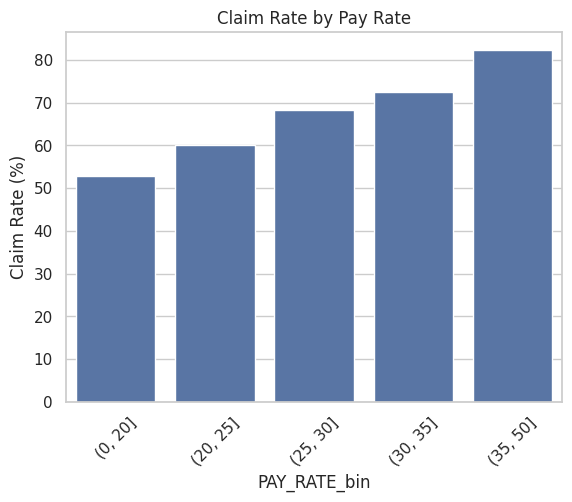

<ipython-input-24-499dd3fb33cb>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = shift_df.groupby(f'{var}_bin')['claimed'].mean().reset_index()


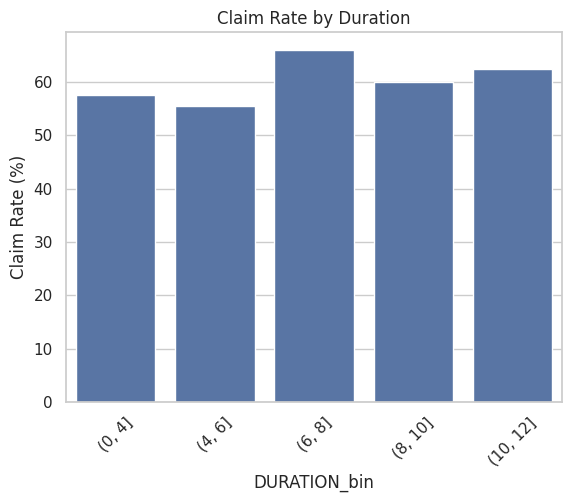

<ipython-input-24-499dd3fb33cb>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = shift_df.groupby(f'{var}_bin')['claimed'].mean().reset_index()


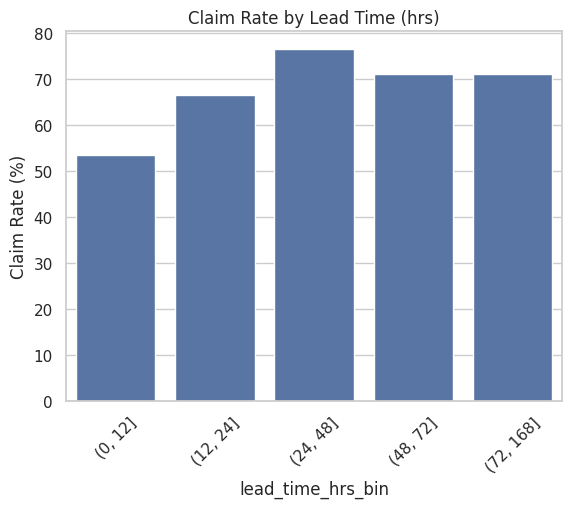

<ipython-input-24-499dd3fb33cb>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = shift_df.groupby(f'{var}_bin')['claimed'].mean().reset_index()


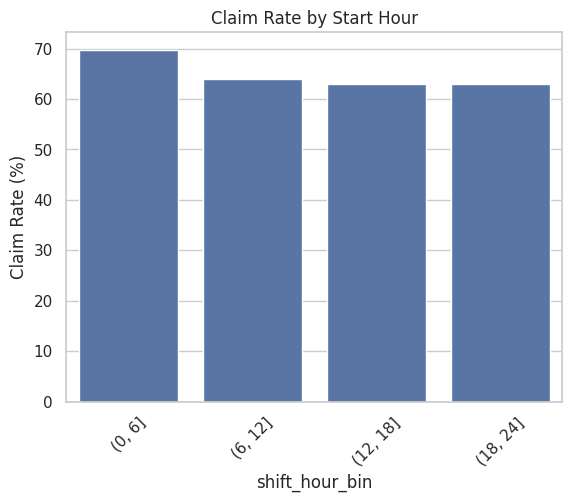

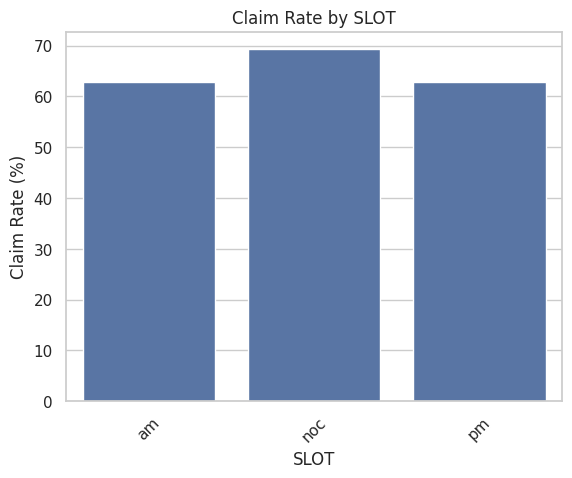

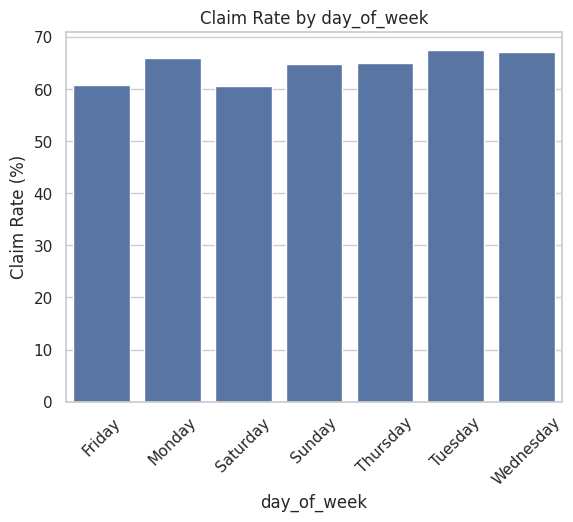

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add lead time and shift hour features
df['lead_time_hrs'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['shift_hour'] = df['SHIFT_START_AT'].dt.hour
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()

# Build shift-level dataset
shift_df = df.groupby('SHIFT_ID').agg({
    'claimed': 'any',
    'PAY_RATE': 'first',
    'DURATION': 'first',
    'SLOT': 'first',
    'lead_time_hrs': 'first',
    'shift_hour': 'first',
    'day_of_week': 'first',
    'WORKPLACE_ID': 'first'
}).reset_index()

# Step 1: Binned plots for continuous variables
def bin_and_plot(var, bins, title):
    shift_df[f'{var}_bin'] = pd.cut(shift_df[var], bins)
    grp = shift_df.groupby(f'{var}_bin')['claimed'].mean().reset_index()
    grp['claimed'] *= 100
    sns.barplot(x=f'{var}_bin', y='claimed', data=grp)
    plt.title(f'Claim Rate by {title}')
    plt.ylabel('Claim Rate (%)')
    plt.xticks(rotation=45)
    plt.show()


bin_and_plot('PAY_RATE', bins=[0, 20, 25, 30, 35, 50], title='Pay Rate')
bin_and_plot('DURATION', bins=[0, 4, 6, 8, 10, 12], title='Duration')
bin_and_plot('lead_time_hrs', bins=[0, 12, 24, 48, 72, 168], title='Lead Time (hrs)')
bin_and_plot('shift_hour', bins=[0, 6, 12, 18, 24], title='Start Hour')

# Step 2: Categorical plots
def cat_plot(var):
    grp = shift_df.groupby(var)['claimed'].mean().reset_index()
    grp['claimed'] *= 100
    sns.barplot(x=var, y='claimed', data=grp)
    plt.title(f'Claim Rate by {var}')
    plt.ylabel('Claim Rate (%)')
    plt.xticks(rotation=45)
    plt.show()

cat_plot('SLOT')
cat_plot('day_of_week')


In [ ]:
# Add number of offers per shift
offer_count_df = df.groupby('SHIFT_ID').agg(
    offer_count=('WORKER_ID', 'count')
).reset_index()

# Merge with your shift-level data
shift_df = shift_df.merge(offer_count_df, on='SHIFT_ID', how='left')


<ipython-input-26-142bbab6e033>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_grp = shift_df.groupby('offer_bin')['claimed'].mean().reset_index()


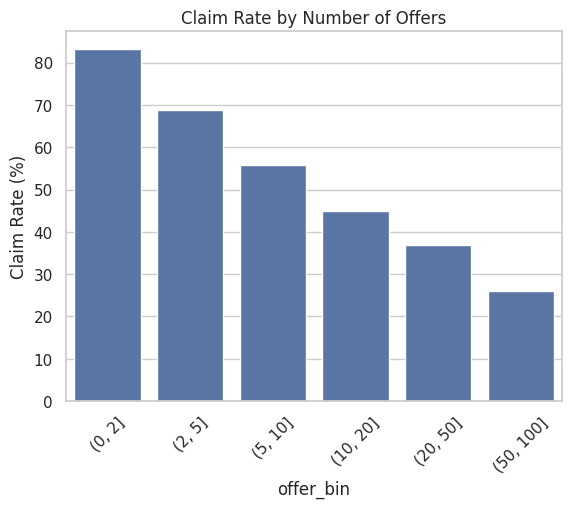

NameError: name 'features' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bin offer counts
shift_df['offer_bin'] = pd.cut(shift_df['offer_count'], bins=[0, 2, 5, 10, 20, 50, 100])

# Plot claim rate by offer bin
offer_grp = shift_df.groupby('offer_bin')['claimed'].mean().reset_index()
offer_grp['claimed'] *= 100

sns.barplot(x='offer_bin', y='claimed', data=offer_grp)
plt.title('Claim Rate by Number of Offers')
plt.ylabel('Claim Rate (%)')
plt.xticks(rotation=45)
plt.show()

# Add offer_count to the model
features.append('offer_count')
numeric_features.append('offer_count')


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# ✅ Add 'offer_count' to features
features = ['PAY_RATE', 'lead_time_hrs', 'shift_hour', 'DURATION', 'SLOT', 'day_of_week', 'WORKPLACE_ID', 'offer_count']
target = 'claimed'

# Drop nulls
model_df = shift_df.dropna(subset=features + [target])

# Train-test split
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Add 'offer_count' to numeric preprocessing
numeric_features = ['PAY_RATE', 'lead_time_hrs', 'shift_hour', 'DURATION', 'offer_count']
categorical_features = ['SLOT', 'day_of_week', 'WORKPLACE_ID']

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
])

# Model pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
clf.fit(X_train, y_train)

# Evaluate performance
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"✅ AUC with WORKPLACE_ID and offer_count: {auc:.3f}")


✅ AUC with WORKPLACE_ID and offer_count: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Replace classifier with Random Forest
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

# Train model
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"🌲 AUC with Random Forest: {auc:.3f}")


🌲 AUC with Random Forest: 0.797


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Use same preprocessor from before
from xgboost import XGBClassifier

# Set up pipeline with XGBoost
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Train model
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"🚀 AUC with XGBoost: {auc:.3f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:13:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 AUC with XGBoost: 0.817


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


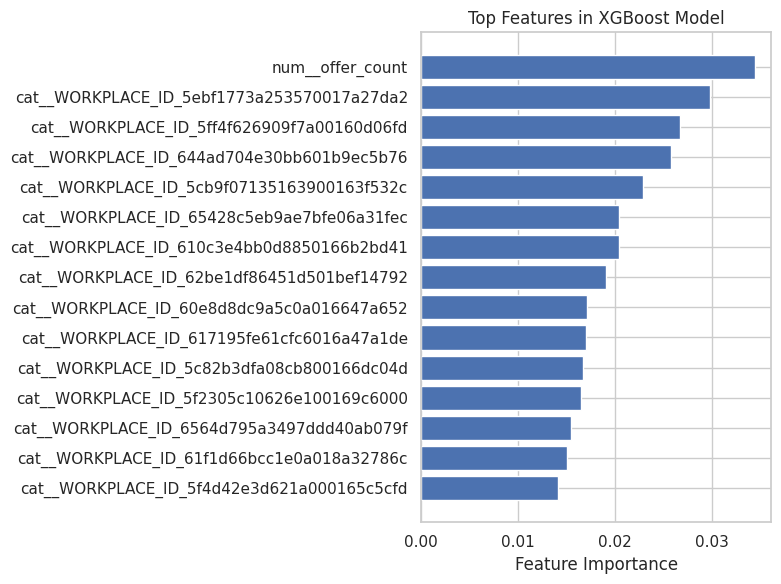

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()
importances = clf.named_steps['classifier'].feature_importances_

# Sort and plot
indices = np.argsort(importances)[-15:]  # top 15
plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Feature Importance")
plt.title("Top Features in XGBoost Model")
plt.tight_layout()
plt.show()


In [ ]:
shift_df['predicted_claim_prob'] = clf.predict_proba(shift_df[features])[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Ensure 'claimed' flag exists
df['claimed'] = df['CLAIMED_AT'].notnull()

# Group by worker
worker_claim_stats = df.groupby('WORKER_ID').agg(
    total_offers=('SHIFT_ID', 'count'),
    claimed_offers=('claimed', 'sum')
).reset_index()

# Calculate claim rate
worker_claim_stats['claim_rate'] = worker_claim_stats['claimed_offers'] / worker_claim_stats['total_offers']
worker_claim_stats['claim_rate'] = worker_claim_stats['claim_rate'].round(3)

# Optional: sort by highest or lowest claimers
worker_claim_stats = worker_claim_stats.sort_values('claim_rate', ascending=True)

# Display top workers
display(worker_claim_stats.head(10))


,WORKER_ID,total_offers,claimed_offers,claim_rate
6725,65c7c502277df9830b4b864d,15,0,0.0
6715,65c63eb9277df9830b9a5cfa,2,0,0.0
6716,65c6506a277df9830b801174,2,0,0.0
6717,65c66284277df9830b600d57,2,0,0.0
6718,65c66646277df9830b8d4cde,60,0,0.0
6719,65c6adc3277df9830bf1fb56,17,0,0.0
6720,65c6e2b7277df9830b2b25ca,11,0,0.0
6721,65c6eb47277df9830b7d680b,1,0,0.0
6722,65c7214f277df9830b61ebf3,1,0,0.0
6723,65c78fc6277df9830b732b7c,1,0,0.0


<ipython-input-33-9ead85bf1872>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_stats = shift_df.groupby('offer_bin')['claimed'].mean().reset_index()


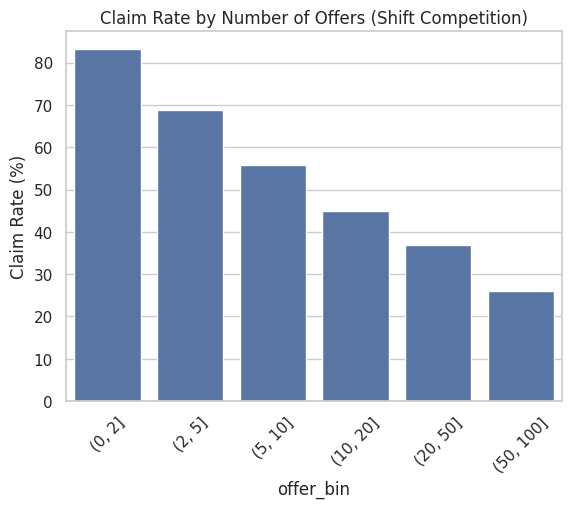

In [ ]:
# Each row is a shift offer to a worker
# So group by SHIFT_ID to count offers
shift_competition = df.groupby('SHIFT_ID').agg(
    offer_count=('WORKER_ID', 'count')  # total offers sent for the shift
).reset_index()

# If offer_count already exists in shift_df, drop it to avoid conflict
shift_df = shift_df.drop(columns=['offer_count'], errors='ignore')

# Now merge safely
shift_df = shift_df.merge(shift_competition, on='SHIFT_ID', how='left')


# Bin offer counts to analyze claim success
shift_df['offer_bin'] = pd.cut(shift_df['offer_count'], bins=[0, 2, 5, 10, 20, 50, 100])

# Calculate claim rate by bin
offer_stats = shift_df.groupby('offer_bin')['claimed'].mean().reset_index()
offer_stats['claimed'] *= 100  # convert to %

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='offer_bin', y='claimed', data=offer_stats)
plt.title('Claim Rate by Number of Offers (Shift Competition)')
plt.ylabel('Claim Rate (%)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
pay_variability = df.groupby('SHIFT_ID')['PAY_RATE'].nunique().value_counts()
print(pay_variability.head())


PAY_RATE
1    6579
2    2334
3    1350
4     928
5     699
Name: count, dtype: int64


<ipython-input-35-97bf8fa5ecb8>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claim_by_avg_pay = shift_avg_pay.groupby('pay_rate_bin')['claimed'].mean().reset_index()


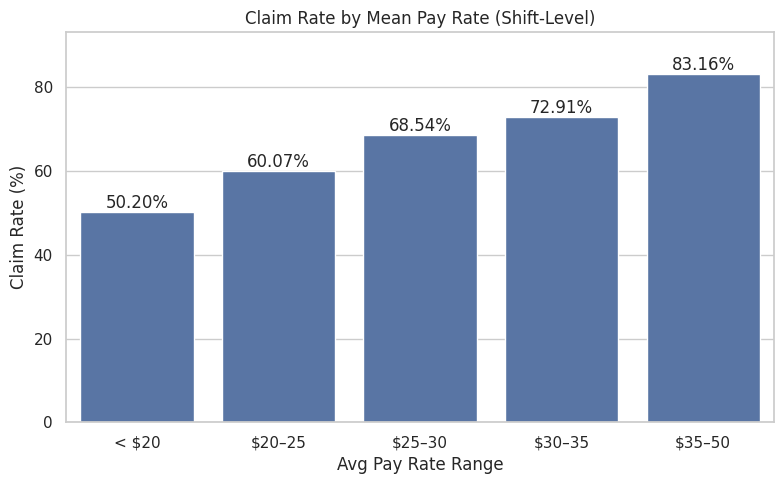

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate to shift-level using mean pay and any claimed
shift_avg_pay = df.groupby('SHIFT_ID').agg({
    'PAY_RATE': 'mean',        # Average pay offered for this shift
    'claimed': 'any'           # Was it claimed at least once?
}).reset_index()

# Step 2: Create bins for average pay
bins = [0, 20, 25, 30, 35, 50]
labels = ['< $20', '$20–25', '$25–30', '$30–35', '$35–50']
shift_avg_pay['pay_rate_bin'] = pd.cut(shift_avg_pay['PAY_RATE'], bins=bins, labels=labels)

# Step 3: Calculate claim rate per pay bin
claim_by_avg_pay = shift_avg_pay.groupby('pay_rate_bin')['claimed'].mean().reset_index()
claim_by_avg_pay['claim_rate_pct'] = claim_by_avg_pay['claimed'] * 100

# Step 4: Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='pay_rate_bin', y='claim_rate_pct', data=claim_by_avg_pay)

# Annotate bars with %
for index, row in claim_by_avg_pay.iterrows():
    plt.text(index, row['claim_rate_pct'] + 1, f"{row['claim_rate_pct']:.2f}%", ha='center')

plt.title("Claim Rate by Mean Pay Rate (Shift-Level)")
plt.ylabel("Claim Rate (%)")
plt.xlabel("Avg Pay Rate Range")
plt.ylim(0, claim_by_avg_pay['claim_rate_pct'].max() + 10)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# STEP 1: Feature Engineering
df['claimed'] = df['CLAIMED_AT'].notnull()
df['lead_time_hrs'] = (pd.to_datetime(df['SHIFT_START_AT']) - pd.to_datetime(df['SHIFT_CREATED_AT'])).dt.total_seconds() / 3600
df['shift_hour'] = pd.to_datetime(df['SHIFT_START_AT']).dt.hour
df['offer_count'] = df.groupby('SHIFT_ID')['WORKER_ID'].transform('count')

# STEP 2: Calculate workplace claim rate
workplace_claim_rate = df.groupby('WORKPLACE_ID')['claimed'].mean().reset_index()
workplace_claim_rate.columns = ['WORKPLACE_ID', 'workplace_claim_rate']
df = df.merge(workplace_claim_rate, on='WORKPLACE_ID', how='left')

# STEP 3: Select features
features = ['workplace_claim_rate', 'offer_count', 'lead_time_hrs', 'shift_hour', 'DURATION', 'PAY_RATE']
X = df[features]
y = df['claimed']

# Drop missing values
X = X.dropna()
y = y[X.index]

# STEP 4: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# STEP 6: Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# STEP 7: Evaluate and output coefficients
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.3f}")

# STEP 8: Coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})
print(coefficients)


✅ Model Accuracy: 0.953
                Feature  Coefficient
0  workplace_claim_rate     0.177557
1           offer_count    -6.188596
2         lead_time_hrs     0.018495
3            shift_hour    -0.026093
4              DURATION    -0.028950
5              PAY_RATE     0.186118


In [ ]:
import numpy as np

# Step 1: Create shift-level dataset using mean values
shift_df = df.groupby('SHIFT_ID').agg({
    'workplace_claim_rate': 'first',
    'offer_count': 'first',
    'lead_time_hrs': 'first',
    'shift_hour': 'first',
    'DURATION': 'first',
    'PAY_RATE': 'first',
    'claimed': 'any'
}).reset_index()

# Step 2: Normalize features using the same scaler as the model
X_raw = shift_df[['workplace_claim_rate', 'offer_count', 'lead_time_hrs', 'shift_hour', 'DURATION', 'PAY_RATE']]
X_scaled = scaler.transform(X_raw)

# Step 3: Calculate predicted claim probabilities
log_odds = (
    0.177557 * X_scaled[:, 0] +
   -6.188596 * X_scaled[:, 1] +
    0.018495 * X_scaled[:, 2] +
   -0.026093 * X_scaled[:, 3] +
   -0.028950 * X_scaled[:, 4] +
    0.186118 * X_scaled[:, 5]
)
claim_prob = 1 / (1 + np.exp(-log_odds))
shift_df['predicted_claim_probability'] = claim_prob

# Step 4: Export to Excel
export_cols = [
    'SHIFT_ID', 'claimed', 'workplace_claim_rate', 'offer_count',
    'lead_time_hrs', 'shift_hour', 'DURATION', 'PAY_RATE', 'predicted_claim_probability'
]
shift_df[export_cols].to_excel("logistic_shift_claim_prediction.xlsx", index=False)
print("✅ Excel file saved: logistic_shift_claim_prediction.xlsx")


✅ Excel file saved: logistic_shift_claim_prediction.xlsx


In [ ]:
print("Means:", scaler.mean_)
print("Stds:", scaler.scale_)


Means: [4.90500864e-02 5.79373132e+01 1.53515319e+02 1.50184351e+01
 8.34216415e+00 2.41649360e+01]
Stds: [4.49975240e-02 5.11975543e+01 2.52075743e+02 6.58037839e+00
 1.15527901e+00 4.65196090e+00]
